# Benchmark an Endpoint

Welcome to this tutorial on benchmarking an endpoint deployed on a SambaNova dedicated node!

If you don't already have an endpoint deployed, please follow one of the workflows described in the [README](./README.md) to deploy an endpoint before proceeding with this tutorial.

Also, please install the benchmarking requirements in the Python kernel used in this Jupyter notebook

`! pip install -r ../../benchmarking/requirements.txt`

## 1.  Imports

In [1]:
import sys
sys.version

'3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
import json
import jsonlines
import os
import pprint
import getpass
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
benchmarking_dir = "../../benchmarking/"
sys.path.append(benchmarking_dir + "src")
sys.path.append(benchmarking_dir + "benchmarking_scripts")
sys.path.append(benchmarking_dir + "../")
from synthetic_performance_eval_script import *
from performance_evaluation import CustomPerformanceEvaluator
from benchmarking.utils import read_perf_eval_json_files

## 2. Get endpoint info
To benchmark the endpoint, we will need to obtain some of its information. Note that this information can be obtained from your SambaNova representative.

#### Enter the endpoint url
Run the cell below and then enter the endpoint URL. This should be in the format of `https://my.env/v1/<endpoint_id>/chat/completions` 

In [4]:
endpoint_url = input().strip()
if endpoint_url[-1] == "/":
    endpoint_url = endpoint_url[:-1]
os.environ["SAMBASTUDIO_URL"] = endpoint_url
endpoint_id = endpoint_url.split('/')[-3]
print("Benchmarking Endpoint:", endpoint_id)

Benchmarking Endpoint: 631938c4-1336-40fd-aa08-9683b4dda499


#### Enter the endpoint API key

In [5]:
endpoint_key = getpass.getpass().strip()
if len(endpoint_key) > 0:
    os.environ["SAMBASTUDIO_API_KEY"] = endpoint_key
else:
    print("Please enter a valid key")

## 3. Automatically retrieve model list from endpoint (Optional)
Run this section only if you don't the have list of models on the endpoint. Note that running this section requires you to first follow the set up instructions given in the [README](./README.md)
#### Set up environment connector
The connector connects to the remote dedicated environment using the variables defined below

In [6]:
env_url = '/'.join(endpoint_url.split('/')[:3])

In [7]:
print("Enter the env access key")
env_key = getpass.getpass().strip()
if len(env_key) > 0:
    os.environ["SAMBASTUDIO_ACCESS_KEY"] = env_key
else:
    print("Please enter a valid key")

Enter the env access key


In [8]:
env_tenant = "default"

In [9]:
from snsdk import SnSdk
sn_env = SnSdk(host_url=env_url, 
                   access_key=env_key, 
                   tenant_id=env_tenant)

#### Get model names in the endpoint

In [10]:
endpoint_info = sn_env.endpoint_info_by_id(endpoint_id)
endpoint_model_id = endpoint_info['targets'][0]["model"]
model_info = sn_env.model_info(endpoint_model_id, job_type="deploy")
model_constituents = [m["name"] for m in model_info["dependencies"]]
sorted(model_constituents)

['Meta-Llama-3.3-70B-Instruct',
 'Qwen-2.5-72B-SD-Qwen-2.5-0.5B',
 'Salesforce--Llama-xLAM-2-70b-fc-r',
 'Salesforce--Llama-xLAM-2-8b-fc-r']

#### Get target model names in the endpoint
Target model names generally differ from model names when the model is a speculative decoding pair

In [11]:
target_models = []
for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name
    target_models.append(model_name)
sorted(target_models)

['Meta-Llama-3.3-70B-Instruct',
 'Qwen2.5-72B-Instruct',
 'Salesforce--Llama-xLAM-2-70b-fc-r',
 'Salesforce--Llama-xLAM-2-8b-fc-r']

## 4. Set up Model Configs for Benchmarking
Note that this section only currently supports a fraction of what the Benchmarking Kit is capable of. You may repurpose this section if you would like to benchmark images or run questions per second (qps).

#### Name the benchmarking run
Give the run a unique name so that the configs and results can be saved with that name. Please note that the name should be compatible with file system path naming rules.

In [6]:
run_name = "llama33_70b_customdata_20250603_1"

#### Specify target models
If not automatically set in Step 3, set Target models as a python list

In [7]:
target_models = ['Meta-Llama-3.3-70B-Instruct']

#### Read custom input file
Note that the file needs to be in jsonl format as shown in the example below. For image prompts, each line should contain a `prompt` key and an `image_path` key. The value of `image_path` should be the image encoded as text.

In [8]:
custom_input_path = f"{benchmarking_dir}/prompts/custom_prompt_example.jsonl"    
prompts = []
with open(custom_input_path, "r") as f:
    for line in f:
        prompts.append(line.strip())
prompts = list(set(prompts))[:5]
prompts

['{"prompt": "Explain the theory of relativity in detail."}',
 '{"prompt": "Summarize this paragraph in one sentence: \'The Industrial Revolution, which took place from the 18th to 19th centuries, was a period during which predominantly agrarian, rural societies in Europe and America became industrial and urban. The revolution saw the rise of mechanized production, improved transportation, and significant social and economic changes.\'"}',
 '{"prompt": "Define \'entropy\' in one sentence."}',
 '{"prompt": "Analyze the impact of artificial intelligence on modern society, considering ethical, economic, and technological aspects. Provide a well-reasoned argument with examples."}',
 '{"prompt": "What is the capital of France?"}']

In [9]:
prompts = ['{"prompt": "Explain the theory of relativity in detail."}',
 '{"prompt": "Given the following text, extract and summarize the key points in a structured format: \'In the past decade, renewable energy has grown significantly due to advancements in technology and governmental incentives. Solar and wind power have become cost-effective alternatives to fossil fuels. However, challenges such as energy storage and infrastructure adaptation remain. Many countries are implementing policies to accelerate the transition toward cleaner energy sources.\'"}',
 '{"prompt": "Here is a list of 20 numbers: 5, 12, 8, 20, 3, 15, 9, 30, 2, 18, 7, 25, 11, 14, 6, 22, 19, 1, 10, 4. Find the median value."}',
 '{"prompt": "Analyze the impact of artificial intelligence on modern society, considering ethical, economic, and technological aspects. Provide a well-reasoned argument with examples."}',
 '{"prompt": "Define \'entropy\' in one sentence."}']

#### Specify configs for benchmarking

In [10]:
output_path = f"{benchmarking_dir}data/benchmarking_tracking_tests/"

config = {
    'sampling_params': {'max_tokens_to_generate': 1000},    
    'output_files_dir': os.path.join(f'{output_path}logs/output_files/', run_name), # each run saved here
    'consolidated_results_dir': os.path.join(f'{output_path}consolidated_results', run_name), # consolidated xlsx saved here
    'timeout': 3600,
    'num_requests': 64,
    'concurrent_requests': [4, 8, 16],
    'save_response_texts': False,
    'llm_api': 'sambastudio'
}

## 5. Run Benchmarking
We will run benchmarking with the configs now

#### Benchmarking produces json files with detailed results for each configuration

In [11]:
for target_model in target_models:
    for num_concurrent_requests in config['concurrent_requests']:        
        for i, prompt in enumerate(prompts):
            # Create file with output
            os.makedirs(config['output_files_dir'], exist_ok=True)
            prompt_file_path = os.path.join(config['output_files_dir'], f"custom_prompt_{i}.jsonl")
            
            with jsonlines.open(prompt_file_path, "w") as writer:
                for j in range(config['num_requests']):
                    writer.write(json.loads(prompt))

            custom_evaluator = CustomPerformanceEvaluator(
                model_name=target_model,        
                results_dir=config['output_files_dir'],
                num_concurrent_requests=num_concurrent_requests,
                timeout=config["timeout"],
                user_metadata={"model_idx": 0},
                input_file_path=prompt_file_path,
                save_response_texts=config['save_response_texts'],
                llm_api=config['llm_api'],
            )
            # Run performance evaluation
            custom_evaluator.run_benchmark(sampling_params=config['sampling_params'])

Running Requests: 100%|██████████| 64/64 [01:04<00:00,  1.26s/it]

2025-06-04 12:12:22,853 [INFO] Tasks Executed!
2025-06-04 12:12:22,854 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:12:22,861 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:12:22,866 [INFO]     p5 = 2.0918
2025-06-04 12:12:22,867 [INFO]     p25 = 2.1059
2025-06-04 12:12:22,868 [INFO]     p50 = 2.1153
2025-06-04 12:12:22,868 [INFO]     p75 = 2.1243
2025-06-04 12:12:22,868 [INFO]     p90 = 2.1344
2025-06-04 12:12:22,869 [INFO]     p95 = 2.1513
2025-06-04 12:12:22,869 [INFO]     p99 = 2.3071
2025-06-04 12:12:22,870 [INFO]     mean = 2.0648
2025-06-04 12:12:22,871 [INFO]     min = 0.296
2025-06-04 12:12:22,871 [INFO]     max = 2.3075
2025-06-04 12:12:22,871 [INFO]     stddev = 0.3222
2025-06-04 12:12:22,871 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:12:22,873 [INFO]     p5 = 3.9989
2025-06-04 12:12:22,873 [INFO]     p25 = 4.0079
202

Running Requests:  97%|█████████▋| 62/64 [00:14<00:00,  3.26it/s]

2025-06-04 12:12:38,522 [INFO] Tasks Executed!
2025-06-04 12:12:38,523 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:12:38,526 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:12:38,528 [INFO]     p5 = 0.5424
2025-06-04 12:12:38,529 [INFO]     p25 = 0.5458
2025-06-04 12:12:38,529 [INFO]     p50 = 0.5533
2025-06-04 12:12:38,530 [INFO]     p75 = 0.5881
2025-06-04 12:12:38,530 [INFO]     p90 = 0.6008
2025-06-04 12:12:38,531 [INFO]     p95 = 0.6072
2025-06-04 12:12:38,531 [INFO]     p99 = 0.7017
2025-06-04 12:12:38,532 [INFO]     mean = 0.5618
2025-06-04 12:12:38,533 [INFO]     min = 0.2128
2025-06-04 12:12:38,534 [INFO]     max = 0.7021
2025-06-04 12:12:38,534 [INFO]     stddev = 0.0572
2025-06-04 12:12:38,534 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:12:38,536 [INFO]     p5 = 0.9098
2025-06-04 12:12:38,536 [INFO]     p25 = 0.9136
20

Running Requests:  97%|█████████▋| 62/64 [00:16<00:00,  2.92it/s]

2025-06-04 12:12:55,505 [INFO] Tasks Executed!
2025-06-04 12:12:55,505 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:12:55,507 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:12:55,509 [INFO]     p5 = 0.5807
2025-06-04 12:12:55,509 [INFO]     p25 = 0.5851
2025-06-04 12:12:55,510 [INFO]     p50 = 0.5915
2025-06-04 12:12:55,510 [INFO]     p75 = 0.6343
2025-06-04 12:12:55,511 [INFO]     p90 = 0.6403
2025-06-04 12:12:55,511 [INFO]     p95 = 0.6455
2025-06-04 12:12:55,511 [INFO]     p99 = 0.7179
2025-06-04 12:12:55,512 [INFO]     mean = 0.6004
2025-06-04 12:12:55,513 [INFO]     min = 0.2035
2025-06-04 12:12:55,513 [INFO]     max = 0.7181
2025-06-04 12:12:55,513 [INFO]     stddev = 0.0601
2025-06-04 12:12:55,514 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:12:55,515 [INFO]     p5 = 0.9962
2025-06-04 12:12:55,515 [INFO]     p25 = 1.0
2025-

Running Requests: 100%|██████████| 64/64 [01:10<00:00,  1.06s/it]

2025-06-04 12:14:06,577 [INFO] Tasks Executed!
2025-06-04 12:14:06,578 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:14:06,580 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:14:06,582 [INFO]     p5 = 2.1415
2025-06-04 12:14:06,583 [INFO]     p25 = 2.1514
2025-06-04 12:14:06,583 [INFO]     p50 = 2.1655
2025-06-04 12:14:06,583 [INFO]     p75 = 2.313
2025-06-04 12:14:06,584 [INFO]     p90 = 2.4329
2025-06-04 12:14:06,584 [INFO]     p95 = 2.4444
2025-06-04 12:14:06,585 [INFO]     p99 = 2.4677
2025-06-04 12:14:06,586 [INFO]     mean = 2.1999
2025-06-04 12:14:06,586 [INFO]     min = 0.1986
2025-06-04 12:14:06,586 [INFO]     max = 2.4834
2025-06-04 12:14:06,587 [INFO]     stddev = 0.2811
2025-06-04 12:14:06,587 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:14:06,589 [INFO]     p5 = 4.3489
2025-06-04 12:14:06,589 [INFO]     p25 = 4.3583
202

Running Requests: 100%|██████████| 64/64 [00:10<00:00,  5.85it/s]

2025-06-04 12:14:18,177 [INFO] Tasks Executed!
2025-06-04 12:14:18,178 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:14:18,181 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:14:18,183 [INFO]     p5 = 0.4228
2025-06-04 12:14:18,183 [INFO]     p25 = 0.4264
2025-06-04 12:14:18,184 [INFO]     p50 = 0.4315
2025-06-04 12:14:18,184 [INFO]     p75 = 0.4555
2025-06-04 12:14:18,185 [INFO]     p90 = 0.464
2025-06-04 12:14:18,185 [INFO]     p95 = 0.4701
2025-06-04 12:14:18,186 [INFO]     p99 = 0.5309
2025-06-04 12:14:18,187 [INFO]     mean = 0.4372
2025-06-04 12:14:18,187 [INFO]     min = 0.1722
2025-06-04 12:14:18,188 [INFO]     max = 0.5311
2025-06-04 12:14:18,188 [INFO]     stddev = 0.0414
2025-06-04 12:14:18,189 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:14:18,191 [INFO]     p5 = 0.6627
2025-06-04 12:14:18,191 [INFO]     p25 = 0.6655
202

Running Requests:  91%|█████████ | 58/64 [00:34<00:07,  1.24s/it]

2025-06-04 12:14:53,763 [INFO] Tasks Executed!
2025-06-04 12:14:53,764 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:14:53,765 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:14:53,767 [INFO]     p5 = 2.0603
2025-06-04 12:14:53,767 [INFO]     p25 = 2.0714
2025-06-04 12:14:53,768 [INFO]     p50 = 2.0801
2025-06-04 12:14:53,768 [INFO]     p75 = 2.1032
2025-06-04 12:14:53,768 [INFO]     p90 = 2.4476
2025-06-04 12:14:53,769 [INFO]     p95 = 2.5682
2025-06-04 12:14:53,769 [INFO]     p99 = 2.5848
2025-06-04 12:14:53,770 [INFO]     mean = 2.1143
2025-06-04 12:14:53,771 [INFO]     min = 0.1732
2025-06-04 12:14:53,771 [INFO]     max = 2.5965
2025-06-04 12:14:53,771 [INFO]     stddev = 0.2914
2025-06-04 12:14:53,772 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:14:53,773 [INFO]     p5 = 4.3205
2025-06-04 12:14:53,774 [INFO]     p25 = 4.3294
20

Running Requests:  91%|█████████ | 58/64 [00:08<00:01,  4.98it/s]

2025-06-04 12:15:03,086 [INFO] Tasks Executed!
2025-06-04 12:15:03,087 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:15:03,089 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:15:03,091 [INFO]     p5 = 0.6367
2025-06-04 12:15:03,091 [INFO]     p25 = 0.6433
2025-06-04 12:15:03,091 [INFO]     p50 = 0.6476
2025-06-04 12:15:03,092 [INFO]     p75 = 0.7138
2025-06-04 12:15:03,092 [INFO]     p90 = 0.7484
2025-06-04 12:15:03,092 [INFO]     p95 = 0.7555
2025-06-04 12:15:03,093 [INFO]     p99 = 0.7571
2025-06-04 12:15:03,094 [INFO]     mean = 0.6666
2025-06-04 12:15:03,095 [INFO]     min = 0.1879
2025-06-04 12:15:03,095 [INFO]     max = 0.7587
2025-06-04 12:15:03,096 [INFO]     stddev = 0.0748
2025-06-04 12:15:03,096 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:15:03,098 [INFO]     p5 = 1.0523
2025-06-04 12:15:03,099 [INFO]     p25 = 1.06
2025

Running Requests:  91%|█████████ | 58/64 [00:09<00:01,  4.28it/s]

2025-06-04 12:15:13,366 [INFO] Tasks Executed!
2025-06-04 12:15:13,367 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:15:13,369 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:15:13,371 [INFO]     p5 = 0.6737
2025-06-04 12:15:13,371 [INFO]     p25 = 0.6789
2025-06-04 12:15:13,372 [INFO]     p50 = 0.6843
2025-06-04 12:15:13,372 [INFO]     p75 = 0.7241
2025-06-04 12:15:13,373 [INFO]     p90 = 0.803
2025-06-04 12:15:13,373 [INFO]     p95 = 0.809
2025-06-04 12:15:13,374 [INFO]     p99 = 0.8092
2025-06-04 12:15:13,375 [INFO]     mean = 0.7027
2025-06-04 12:15:13,376 [INFO]     min = 0.1881
2025-06-04 12:15:13,376 [INFO]     max = 0.8093
2025-06-04 12:15:13,376 [INFO]     stddev = 0.0806
2025-06-04 12:15:13,377 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:15:13,378 [INFO]     p5 = 1.1382
2025-06-04 12:15:13,379 [INFO]     p25 = 1.144
2025-

Running Requests:  92%|█████████▏| 59/64 [00:38<00:06,  1.35s/it]

2025-06-04 12:15:52,374 [INFO] Tasks Executed!
2025-06-04 12:15:52,375 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:15:52,378 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:15:52,379 [INFO]     p5 = 2.2486
2025-06-04 12:15:52,380 [INFO]     p25 = 2.2687
2025-06-04 12:15:52,380 [INFO]     p50 = 2.2728
2025-06-04 12:15:52,380 [INFO]     p75 = 2.277
2025-06-04 12:15:52,381 [INFO]     p90 = 2.658
2025-06-04 12:15:52,381 [INFO]     p95 = 2.7988
2025-06-04 12:15:52,381 [INFO]     p99 = 2.8058
2025-06-04 12:15:52,382 [INFO]     mean = 2.3035
2025-06-04 12:15:52,382 [INFO]     min = 0.1772
2025-06-04 12:15:52,383 [INFO]     max = 2.8097
2025-06-04 12:15:52,383 [INFO]     stddev = 0.3168
2025-06-04 12:15:52,384 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:15:52,385 [INFO]     p5 = 4.7346
2025-06-04 12:15:52,385 [INFO]     p25 = 4.7492
2025

Running Requests: 100%|██████████| 64/64 [00:06<00:00,  9.42it/s]

2025-06-04 12:15:59,526 [INFO] Tasks Executed!
2025-06-04 12:15:59,526 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:15:59,528 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:15:59,530 [INFO]     p5 = 0.5078
2025-06-04 12:15:59,531 [INFO]     p25 = 0.5172
2025-06-04 12:15:59,531 [INFO]     p50 = 0.5233
2025-06-04 12:15:59,531 [INFO]     p75 = 0.531
2025-06-04 12:15:59,532 [INFO]     p90 = 0.6247
2025-06-04 12:15:59,532 [INFO]     p95 = 0.6452
2025-06-04 12:15:59,533 [INFO]     p99 = 0.6464
2025-06-04 12:15:59,534 [INFO]     mean = 0.5355
2025-06-04 12:15:59,534 [INFO]     min = 0.2039
2025-06-04 12:15:59,535 [INFO]     max = 0.647
2025-06-04 12:15:59,535 [INFO]     stddev = 0.0591
2025-06-04 12:15:59,536 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:15:59,537 [INFO]     p5 = 0.7777
2025-06-04 12:15:59,538 [INFO]     p25 = 0.7837
2025

Running Requests: 100%|██████████| 64/64 [00:20<00:00,  3.42it/s]

2025-06-04 12:16:20,543 [INFO] Tasks Executed!
2025-06-04 12:16:20,544 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:16:20,546 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:16:20,547 [INFO]     p5 = 2.2318
2025-06-04 12:16:20,548 [INFO]     p25 = 2.2396
2025-06-04 12:16:20,548 [INFO]     p50 = 2.2493
2025-06-04 12:16:20,548 [INFO]     p75 = 2.357
2025-06-04 12:16:20,549 [INFO]     p90 = 2.3703
2025-06-04 12:16:20,549 [INFO]     p95 = 2.374
2025-06-04 12:16:20,549 [INFO]     p99 = 3.2368
2025-06-04 12:16:20,550 [INFO]     mean = 2.287
2025-06-04 12:16:20,550 [INFO]     min = 0.2238
2025-06-04 12:16:20,550 [INFO]     max = 3.2527
2025-06-04 12:16:20,551 [INFO]     stddev = 0.3362
2025-06-04 12:16:20,551 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:16:20,553 [INFO]     p5 = 5.0008
2025-06-04 12:16:20,553 [INFO]     p25 = 5.0067
2025-

Running Requests:  95%|█████████▌| 61/64 [00:05<00:00,  5.44it/s]

2025-06-04 12:16:26,767 [INFO] Tasks Executed!
2025-06-04 12:16:26,768 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:16:26,770 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:16:26,772 [INFO]     p5 = 0.8222
2025-06-04 12:16:26,773 [INFO]     p25 = 0.8302
2025-06-04 12:16:26,774 [INFO]     p50 = 0.8371
2025-06-04 12:16:26,774 [INFO]     p75 = 0.9494
2025-06-04 12:16:26,775 [INFO]     p90 = 0.9564
2025-06-04 12:16:26,775 [INFO]     p95 = 0.9847
2025-06-04 12:16:26,775 [INFO]     p99 = 0.9863
2025-06-04 12:16:26,776 [INFO]     mean = 0.8545
2025-06-04 12:16:26,776 [INFO]     min = 0.2223
2025-06-04 12:16:26,777 [INFO]     max = 0.9863
2025-06-04 12:16:26,777 [INFO]     stddev = 0.1292
2025-06-04 12:16:26,778 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:16:26,779 [INFO]     p5 = 1.33
2025-06-04 12:16:26,779 [INFO]     p25 = 1.3363
2025

Running Requests: 100%|██████████| 64/64 [00:06<00:00,  6.58it/s]

2025-06-04 12:16:33,863 [INFO] Tasks Executed!
2025-06-04 12:16:33,864 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:16:33,867 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:16:33,869 [INFO]     p5 = 0.8258
2025-06-04 12:16:33,870 [INFO]     p25 = 0.8315
2025-06-04 12:16:33,870 [INFO]     p50 = 0.942
2025-06-04 12:16:33,870 [INFO]     p75 = 0.955
2025-06-04 12:16:33,870 [INFO]     p90 = 1.0661
2025-06-04 12:16:33,871 [INFO]     p95 = 1.0845
2025-06-04 12:16:33,871 [INFO]     p99 = 1.5326
2025-06-04 12:16:33,872 [INFO]     mean = 0.9262
2025-06-04 12:16:33,872 [INFO]     min = 0.205
2025-06-04 12:16:33,873 [INFO]     max = 1.535
2025-06-04 12:16:33,873 [INFO]     stddev = 0.1782
2025-06-04 12:16:33,874 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:16:33,876 [INFO]     p5 = 1.3925
2025-06-04 12:16:33,877 [INFO]     p25 = 1.3986
2025-0

Running Requests: 100%|██████████| 64/64 [00:22<00:00,  1.10it/s]

2025-06-04 12:16:57,135 [INFO] Tasks Executed!
2025-06-04 12:16:57,135 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:16:57,138 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:16:57,140 [INFO]     p5 = 2.5281
2025-06-04 12:16:57,140 [INFO]     p25 = 2.5372
2025-06-04 12:16:57,140 [INFO]     p50 = 2.547
2025-06-04 12:16:57,141 [INFO]     p75 = 2.692
2025-06-04 12:16:57,141 [INFO]     p90 = 2.6949
2025-06-04 12:16:57,141 [INFO]     p95 = 3.4957
2025-06-04 12:16:57,142 [INFO]     p99 = 3.5004
2025-06-04 12:16:57,143 [INFO]     mean = 2.5911
2025-06-04 12:16:57,143 [INFO]     min = 0.2353
2025-06-04 12:16:57,143 [INFO]     max = 3.5023
2025-06-04 12:16:57,143 [INFO]     stddev = 0.5079
2025-06-04 12:16:57,144 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:16:57,145 [INFO]     p5 = 5.5279
2025-06-04 12:16:57,146 [INFO]     p25 = 5.5437
2025

Running Requests: 100%|██████████| 64/64 [00:05<00:00,  6.45it/s]

2025-06-04 12:17:03,143 [INFO] Tasks Executed!
2025-06-04 12:17:03,143 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-04 12:17:03,146 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-04 12:17:03,149 [INFO]     p5 = 0.7968
2025-06-04 12:17:03,149 [INFO]     p25 = 0.8616
2025-06-04 12:17:03,150 [INFO]     p50 = 0.8744
2025-06-04 12:17:03,150 [INFO]     p75 = 0.942
2025-06-04 12:17:03,151 [INFO]     p90 = 0.9497
2025-06-04 12:17:03,151 [INFO]     p95 = 1.359
2025-06-04 12:17:03,151 [INFO]     p99 = 1.3842
2025-06-04 12:17:03,152 [INFO]     mean = 0.9063
2025-06-04 12:17:03,153 [INFO]     min = 0.2144
2025-06-04 12:17:03,153 [INFO]     max = 1.3847
2025-06-04 12:17:03,154 [INFO]     stddev = 0.1663
2025-06-04 12:17:03,154 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-04 12:17:03,156 [INFO]     p5 = 1.1259
2025-06-04 12:17:03,157 [INFO]     p25 = 1.1927
2025

#### Consolidate all results into pandas dataframe

In [12]:
output_files_dir = config['output_files_dir']
df_summary = read_perf_eval_json_files(output_files_dir, type='summary')
missing_columns = []

if 'num_concurrent_requests' not in df_summary.columns:
    missing_columns.append('num_concurrent_requests')

if 'multimodal_img_size' not in df_summary.columns or df_summary['multimodal_img_size'].isnull().all():
    missing_columns.append('multimodal_img_size')

# Set fields to report
selected_columns = [
    'name',
    'model',    
    'number_input_tokens_min',
    'number_input_tokens_max',
    'number_output_tokens_min',
    'number_output_tokens_max',
    'num_concurrent_requests',
    'multimodal_img_size',
    'server_ttft_s_min',
    'server_ttft_s_p50',
    'server_ttft_s_max',
    'server_end_to_end_latency_s_min',
    'server_end_to_end_latency_s_p50',
    'server_end_to_end_latency_s_max',
    'server_output_token_per_s_min',
    'server_output_token_per_s_p50',
    'server_output_token_per_s_max',
    'server_output_token_per_s_mean',                
    'acceptance_rate_min',
    'acceptance_rate_p50',
    'acceptance_rate_max',
    'server_number_input_tokens_p50',
    'server_number_output_tokens_p50',
    'client_ttft_s_min',
    'client_ttft_s_p50',
    'client_ttft_s_max',
    'client_end_to_end_latency_s_min',
    'client_end_to_end_latency_s_p50',
    'client_end_to_end_latency_s_max',
    'client_output_token_per_s_min',
    'client_output_token_per_s_p50',
    'client_output_token_per_s_max',
    'client_output_token_per_s_mean',
    'client_mean_output_token_per_s',
    'num_requests_started',
    'num_completed_requests',
    'num_completed_requests_per_min',
    'number_errors',
    'error_code_frequency',
]

selected_columns = [c for c in selected_columns if c not in missing_columns]
# Set fields to report
df_summary = df_summary[selected_columns]
df_summary['model'] = df_summary['model'].str.replace('.', '-')
df_summary['requests_grouping'] = pd.Series(None, index=df_summary.index, dtype=object)
df_summary['requests_batching'] = pd.Series(None, index=df_summary.index, dtype=object)

# Add UUID to summary and set as index
#df_summary['uuid'] = df_summary.apply(lambda x: find_uuid(x['name']), axis=1)
df_summary = df_summary.set_index('name')

# Read individual responses
df = read_perf_eval_json_files(output_files_dir, type='individual_responses')

# Process individual files and add requests batching approximation
for filename in os.listdir(output_files_dir):
    if 'individual_responses' in filename:
        df_file = df[df['filename'] == filename].copy()
        df_file = df_file[df_file['error_code'].isnull()]

        requests_grouping, requests_batching = get_grouping_and_batching_info(df_file)

        key = filename[:filename.index("_individual_responses.json")] + "_summary"
        total_input_tokens = df_file["number_input_tokens"].sum()
        total_output_tokens = df_file["number_output_tokens"].sum()

        if key in df_summary.index:
            df_summary.at[key, 'requests_grouping'] = requests_grouping
            df_summary.at[key, 'requests_batching'] = requests_batching
            df_summary.at[key, 'total_input_tokens'] = total_input_tokens
            df_summary.at[key, 'total_output_tokens'] = total_output_tokens
        else:
            raise KeyError(f'Key {key} not found in dictionary. File: {file}')
df_summary['representative_batch_size'] = df_summary['requests_batching'].apply(
    lambda x: find_median_in_batches(x)
)

# Sort and save the summary DataFrame
consolidated_results_dir = os.path.expanduser(config['consolidated_results_dir'])
if not os.path.exists(consolidated_results_dir):
    os.makedirs(consolidated_results_dir)

df_summary["number_input_tokens_min"] = df_summary["number_input_tokens_min"].astype(int)
df_summary["number_output_tokens_min"] = df_summary["number_output_tokens_min"].astype(int)

sort_columns = ['model', 'num_concurrent_requests', 'number_input_tokens_min', 'number_output_tokens_min']
if 'num_concurrent_requests' in df_summary.columns:
    sort_columns.append('num_concurrent_requests')
df_summary.sort_values(by=sort_columns, inplace=True)

df_summary["server_rated_throughput"] = df_summary["server_output_token_per_s_mean"] * df_summary["representative_batch_size"]
df_summary["total_latency"] =  df_summary["num_completed_requests"]*60/df_summary["num_completed_requests_per_min"]
df_summary["client_output_throughput"] = df_summary["total_output_tokens"]/df_summary["total_latency"]
df_summary["client_total_throughput"] = (df_summary["total_input_tokens"]+df_summary["total_output_tokens"])/df_summary["total_latency"]

df_summary.to_excel(os.path.join(consolidated_results_dir, f'{run_name}.xlsx'))


## 6. Compare with alternative benchmarking results

In [22]:
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [23]:
current_name = "Old CustomPerformanceEvaluator"
alt_name = "New CustomPromptPerformanceEvaluator"

#### Read results from current run

In [24]:
current_file_path = os.path.join(config["consolidated_results_dir"], f'{run_name}.xlsx')
df_current = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_current["provider"] = current_name
df_current.head()

,name,model,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,total_input_tokens,total_output_tokens,representative_batch_size,server_rated_throughput,total_latency,client_output_throughput,client_total_throughput,provider
0,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,39,39,496,496,1,0.0689,0.0705,0.0727,1.5054,1.5216,1.5495,335.0987,338.9868,341.9445,338.9717,NaN,NaN,NaN,39,496,0.1718,0.2784,0.7031,1.6192,1.7512,2.2509,267.4009,339.7231,343.6710,334.6390,276.8928,64,64,33.4951,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2496,31744,1,338.9717,114.643634,276.892827,298.664642,Old CustomPerformanceEvaluator
1,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,80,80,1000,1000,1,0.0694,0.0711,0.0743,3.0552,3.0867,3.1400,325.7880,329.8242,333.2707,329.8230,NaN,NaN,NaN,80,1000,0.1784,0.3308,1.0947,3.1956,3.3522,4.1016,296.9134,329.7317,334.8848,327.9023,291.1643,64,64,17.4699,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5120,64000,1,329.8230,219.806639,291.165000,314.458200,Old CustomPerformanceEvaluator
2,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,1688,1688,1000,1000,1,0.2013,0.2027,0.2052,3.5059,3.5361,3.5759,295.0515,299.0670,301.5753,298.8332,NaN,NaN,NaN,1688,1000,0.3151,0.4879,1.4103,3.6415,3.8430,4.7825,257.9037,298.6280,310.9777,297.4240,256.4624,64,64,15.3877,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",108032,64000,1,298.8332,249.549965,256.461667,689.368960,Old CustomPerformanceEvaluator
3,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,1955,1955,809,809,1,0.2013,0.2027,0.2056,2.8946,2.9196,2.9571,293.4256,296.2649,299.3810,296.5218,NaN,NaN,NaN,1955,809,0.3307,0.5007,1.0516,3.0180,3.2430,3.8626,266.1731,296.6982,322.3532,293.9939,245.3997,64,64,18.2002,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",125120,51776,1,296.5218,210.986692,245.399363,838.422547,Old CustomPerformanceEvaluator
4,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,3417,3417,402,402,1,0.3746,0.3761,0.3782,1.4141,1.4280,1.4409,374.5346,380.6704,385.2268,380.6722,NaN,NaN,NaN,3417,402,0.5073,0.6919,2.0518,1.5559,1.7967,3.1559,243.2928,382.0410,428.5887,364.2633,216.9541,64,64,32.3812,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",218688,25728,1,380.6722,118.587328,216.954040,2061.063380,Old CustomPerformanceEvaluator


#### Read results from alternative source

In [27]:
alt_run_name = "llama33_70b_sd_1b_short_studio_sfdata_20250602_1"
alt_file_path = os.path.join(f'{output_path}consolidated_results', alt_run_name, f'{alt_run_name}.xlsx')
df_alt = pd.read_excel(alt_file_path, sheet_name='Sheet1')
df_alt["provider"] = alt_name
df_alt.head()

,name,model,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,total_input_tokens,total_output_tokens,representative_batch_size,server_rated_throughput,total_latency,client_output_throughput,client_total_throughput,provider
0,synthetic_0_Meta-Llama-3-3-70B-Instruct_0_1000...,Meta-Llama-3-3-70B-Instruct,39,39,496,496,1,0.0691,0.0723,0.0766,1.5130,1.5266,1.5581,333.5770,337.8375,342.3656,338.0911,NaN,NaN,NaN,39,496,0.1686,0.2808,0.7583,1.6157,1.7567,2.4404,268.7738,338.5953,347.8019,331.8455,274.2699,64,64,33.1778,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2496,31744,1,338.0911,115.740043,274.269813,295.835383,New CustomPromptPerformanceEvaluator
1,synthetic_0_Meta-Llama-3-3-70B-Instruct_1_1000...,Meta-Llama-3-3-70B-Instruct,80,80,1000,1000,1,0.0694,0.0719,0.0747,3.0522,3.0900,3.1353,326.1153,328.9144,333.7129,329.0694,NaN,NaN,NaN,80,1000,0.1713,0.3272,0.9903,3.1948,3.3553,4.1669,306.4995,329.5512,334.8144,328.7933,293.6662,64,64,17.6200,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5120,64000,1,329.0694,217.934166,293.666667,317.160000,New CustomPromptPerformanceEvaluator
2,synthetic_0_Meta-Llama-3-3-70B-Instruct_2_1000...,Meta-Llama-3-3-70B-Instruct,1688,1688,1000,1000,1,0.2005,0.2037,0.2061,3.5109,3.5574,3.5797,295.5842,297.5359,300.8714,297.9287,NaN,NaN,NaN,1688,1000,0.3200,0.4593,1.0482,3.6522,3.7930,4.4123,257.5206,298.8217,310.7804,298.5541,259.4201,64,64,15.5652,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",108032,64000,1,297.9287,246.704186,259.420000,697.320960,New CustomPromptPerformanceEvaluator
3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3_1000...,Meta-Llama-3-3-70B-Instruct,1955,1955,809,809,1,0.2022,0.2040,0.2059,2.8917,2.9342,2.9575,293.5560,295.3114,299.0403,295.3631,NaN,NaN,NaN,1955,809,0.3300,0.4560,2.3432,3.0551,3.1778,5.0887,248.1662,296.4497,309.5396,293.9722,245.1368,64,64,18.1807,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",125120,51776,1,295.3631,211.212990,245.136438,837.524247,New CustomPromptPerformanceEvaluator
4,synthetic_0_Meta-Llama-3-3-70B-Instruct_4_1000...,Meta-Llama-3-3-70B-Instruct,3417,3417,402,402,1,0.3753,0.3767,0.3801,1.4128,1.4308,1.4469,369.8218,379.1978,384.9822,379.1761,NaN,NaN,NaN,3417,402,0.5070,0.6971,2.1206,1.5601,1.7710,3.4071,220.9643,379.2784,443.5685,363.6444,216.2365,64,64,32.2741,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",218688,25728,1,379.1761,118.980855,216.236470,2054.246465,New CustomPromptPerformanceEvaluator


#### Combine dataframes

In [28]:
df_current.shape, df_alt.shape

((14, 48), (42, 48))

In [29]:
common_columns = list(set(df_current.columns) & set(df_alt.columns)) # get intersection
common_columns = [c for c in df_current.columns if c in common_columns] # reorder
len(common_columns)

48

In [30]:
first_columns = ['provider','model','num_concurrent_requests', 'total_input_tokens','total_output_tokens', 'total_latency', 'server_rated_throughput', 'client_output_throughput', 'client_total_throughput']
following_columns = [column for column in common_columns if column not in first_columns]
results = pd.concat([
        df_current,
        df_alt
    ], axis=0
)[first_columns + following_columns]
results.head()

,provider,model,num_concurrent_requests,total_input_tokens,total_output_tokens,total_latency,server_rated_throughput,client_output_throughput,client_total_throughput,name,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size
0,Old CustomPerformanceEvaluator,Meta-Llama-3-3-70B-Instruct,1,2496,31744,114.643634,338.9717,276.892827,298.664642,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,39,39,496,496,0.0689,0.0705,0.0727,1.5054,1.5216,1.5495,335.0987,338.9868,341.9445,338.9717,NaN,NaN,NaN,39,496,0.1718,0.2784,0.7031,1.6192,1.7512,2.2509,267.4009,339.7231,343.6710,334.6390,276.8928,64,64,33.4951,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,Old CustomPerformanceEvaluator,Meta-Llama-3-3-70B-Instruct,1,5120,64000,219.806639,329.8230,291.165000,314.458200,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,80,80,1000,1000,0.0694,0.0711,0.0743,3.0552,3.0867,3.1400,325.7880,329.8242,333.2707,329.8230,NaN,NaN,NaN,80,1000,0.1784,0.3308,1.0947,3.1956,3.3522,4.1016,296.9134,329.7317,334.8848,327.9023,291.1643,64,64,17.4699,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,Old CustomPerformanceEvaluator,Meta-Llama-3-3-70B-Instruct,1,108032,64000,249.549965,298.8332,256.461667,689.368960,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,1688,1688,1000,1000,0.2013,0.2027,0.2052,3.5059,3.5361,3.5759,295.0515,299.0670,301.5753,298.8332,NaN,NaN,NaN,1688,1000,0.3151,0.4879,1.4103,3.6415,3.8430,4.7825,257.9037,298.6280,310.9777,297.4240,256.4624,64,64,15.3877,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,Old CustomPerformanceEvaluator,Meta-Llama-3-3-70B-Instruct,1,125120,51776,210.986692,296.5218,245.399363,838.422547,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,1955,1955,809,809,0.2013,0.2027,0.2056,2.8946,2.9196,2.9571,293.4256,296.2649,299.3810,296.5218,NaN,NaN,NaN,1955,809,0.3307,0.5007,1.0516,3.0180,3.2430,3.8626,266.1731,296.6982,322.3532,293.9939,245.3997,64,64,18.2002,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,Old CustomPerformanceEvaluator,Meta-Llama-3-3-70B-Instruct,1,218688,25728,118.587328,380.6722,216.954040,2061.063380,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,3417,3417,402,402,0.3746,0.3761,0.3782,1.4141,1.4280,1.4409,374.5346,380.6704,385.2268,380.6722,NaN,NaN,NaN,3417,402,0.5073,0.6919,2.0518,1.5559,1.7967,3.1559,243.2928,382.0410,428.5887,364.2633,216.9541,64,64,32.3812,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


### Plot benchmarking charts among providers

You may change the pallette color based on the color that better identifies each provider. You can take the [following link](https://seaborn.pydata.org/tutorial/color_palettes.html) as reference. Also, you will need to update the suptitle to reflect the model you're showing and any other detail. 

<Figure size 640x480 with 0 Axes>

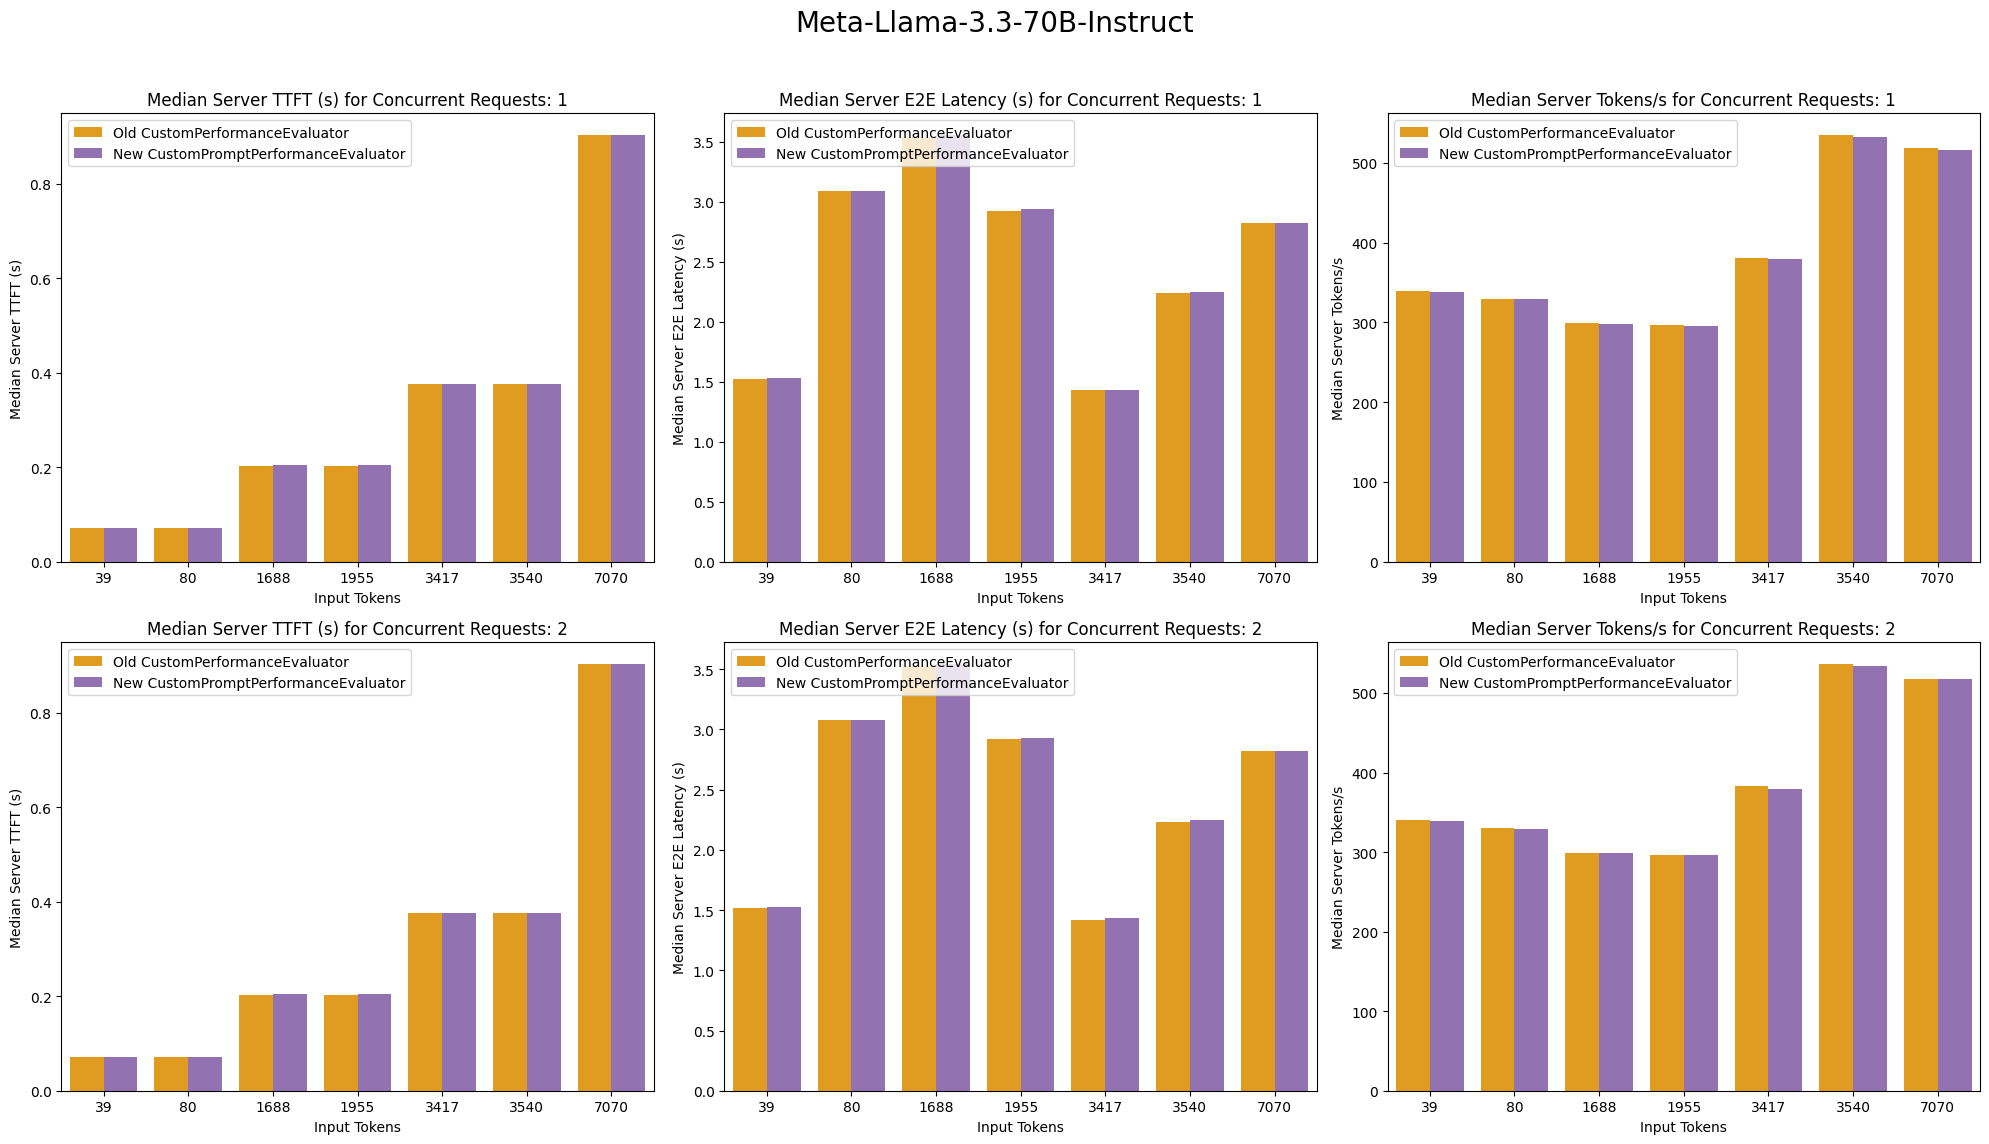

In [31]:
%matplotlib inline

# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Median Server TTFT (s)": "server_ttft_s_p50",
    "Median Server E2E Latency (s)": "server_end_to_end_latency_s_p50",
    "Median Server Tokens/s": "server_output_token_per_s_p50",
}

# Get unique concurrent values
concurrent_values = sorted(config['concurrent_requests'])

plt.clf()
for target_model in target_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), 3, figsize=(20, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='number_input_tokens_min', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

<Figure size 640x480 with 0 Axes>

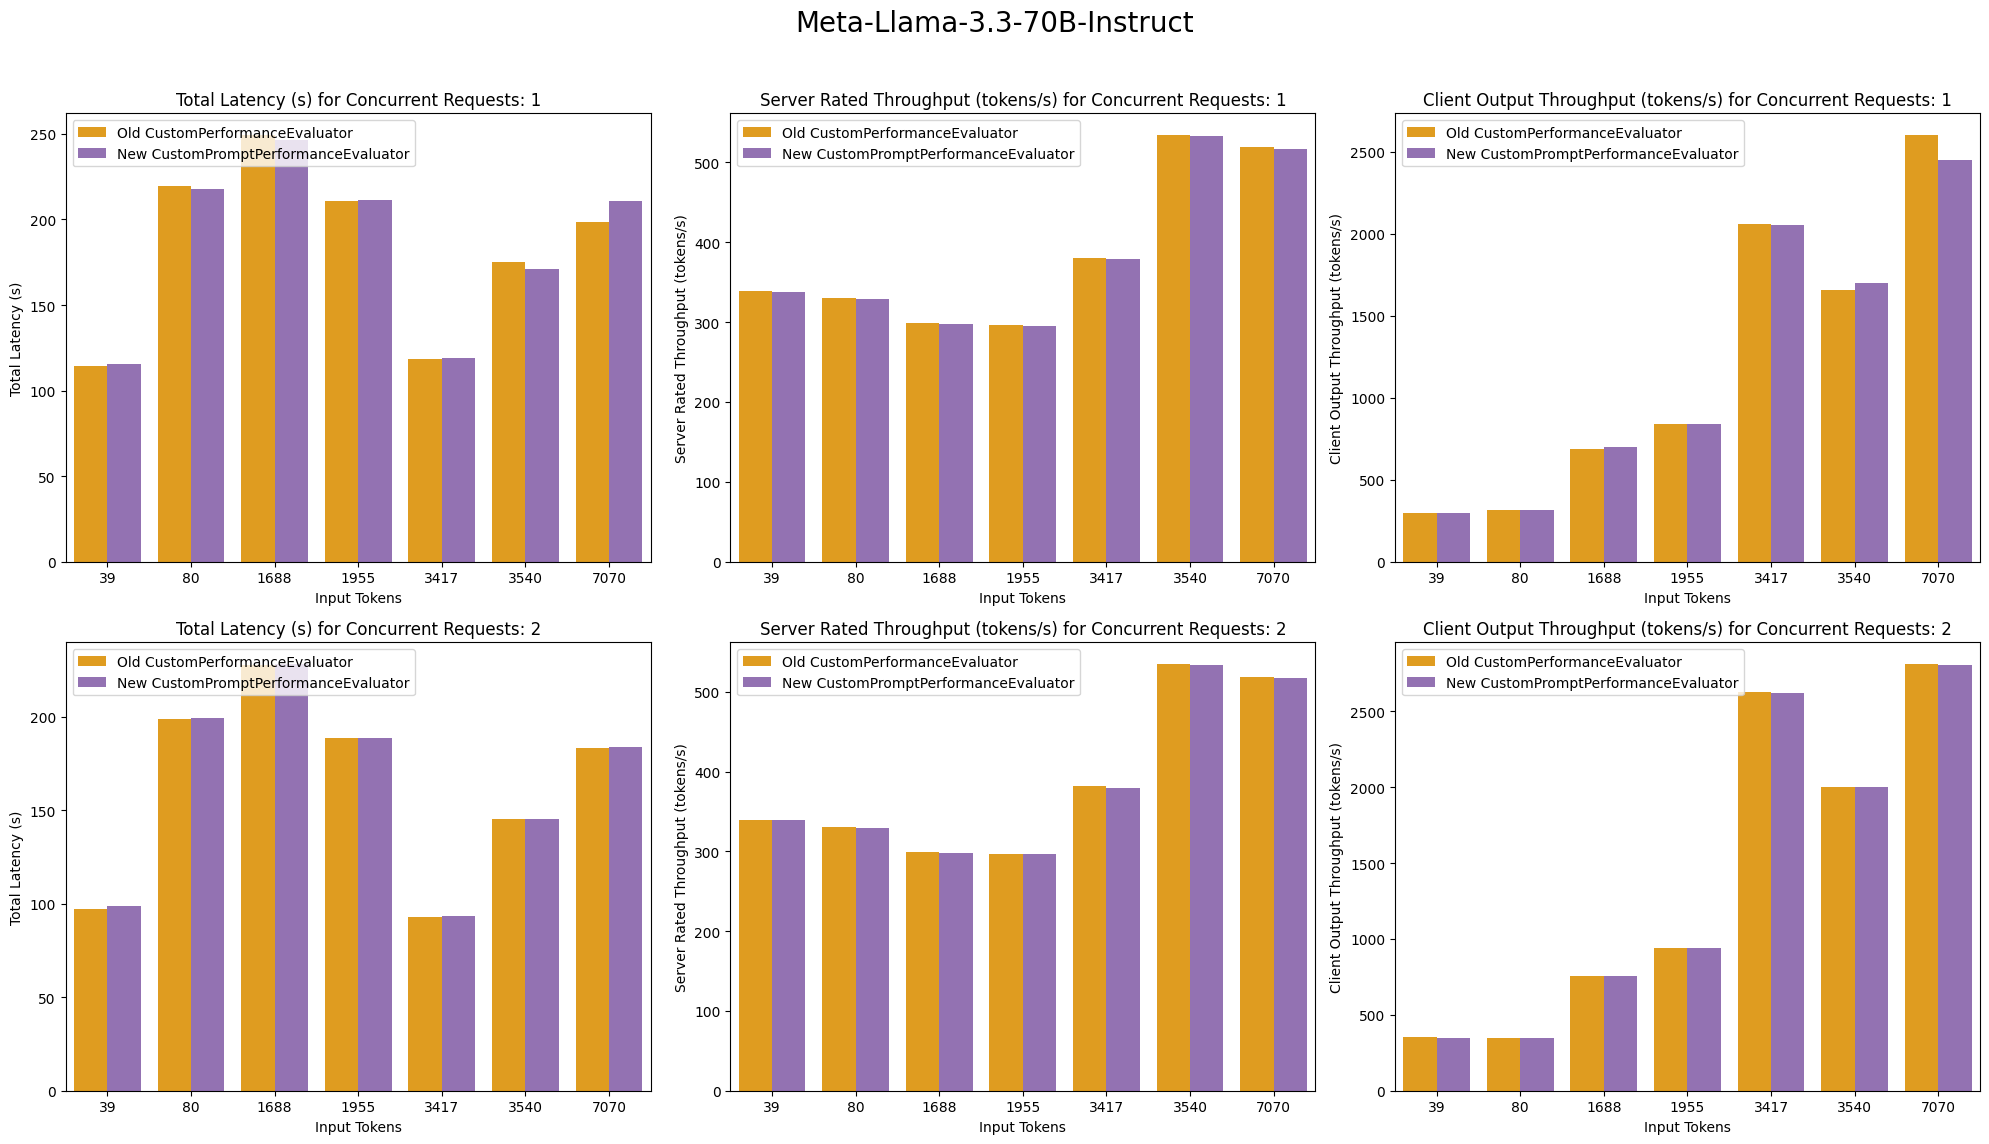

In [33]:
%matplotlib inline

# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Total Latency (s)": "total_latency",
    "Server Rated Throughput (tokens/s)": "server_rated_throughput",
    "Client Output Throughput (tokens/s)": "client_total_throughput",
}

# Get unique concurrent values
concurrent_values = sorted(config['concurrent_requests'])

plt.clf()
for target_model in target_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), 3, figsize=(20, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='number_input_tokens_min', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

